# Detection and Quantification in ISCAT

In this notebook we will investigate how to detect and quantify particles in ISCAT. 

The notebook contains the following sections:

1. Imports 
    - Importing the packages needed to run the code.
2. Detection in ISCAT
    - We leverage two different methods for particle detection: the Radial Variance Transform(RVT) and LodeSTAR.
3. Quantification of particle properties in ISCAT
    - Here we show how to simulate particles in the ISCAT regime and train a Convolutional Neural Network(CNN) for the quantification task.
    - We provide figures of how the estimated signal scales with fixed radius aswell as with fixed refractive index and corresponding theoretical curves.
4. Combining detection and quantification in ISCAT
    - Here we provide a short example on how to analyze an entire frame by performing tracking with LodeSTAR and signal quantification with a CNN.




## 1. Imports

In [1]:
import deeptrack as dt
import deeptrack.deeplay as dl

In [2]:
import help_files as hp #Helper functions for the notebook.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage
import torch

In [4]:
DEV = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running code on device: ({DEV}) when possible")

Running code on device: (cuda) when possible


## 2. Detection in ISCAT

Let's start by loading in data in the ISCAT regime.

In [5]:
data_path = os.path.join("..", "data", "iscat", "iscat_data.npy")
labels_path = os.path.join("..", "data", "iscat", "iscat_labels.npy")

In [6]:
data = np.load(data_path) #ISCAT image
labels = np.load(labels_path) #Labels for the particles
centroids = labels[:, 0:2] #Centroids of the particles

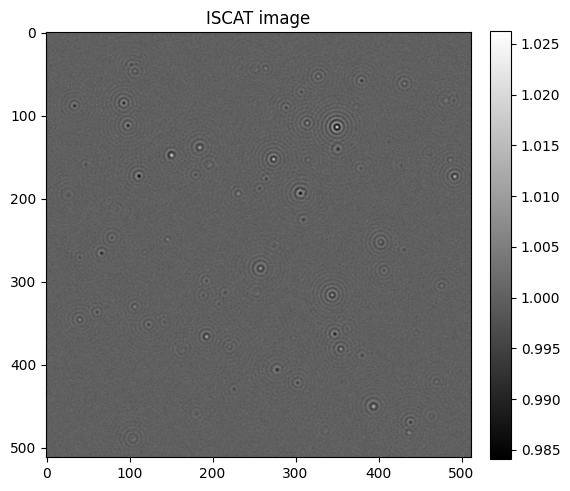

In [7]:
plt.figure(figsize=(6,6))
im = plt.imshow(data[...,0], cmap="gray")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("ISCAT image")
plt.show()

Subtract 1 so data is centered around 0 instead of 1.

In [8]:
data = data - 1

### 2.1 Detecting particles using Radial Variance Transform (RVT)


We present an example demonstrating the use of the Radial Variance Transform (RVT) for particle detection, a method which is highly efficient and has shown great results on particle detection tasks. 

You can find the implementation of this algorithm on GitHub:
[Radial Variance Transform for Particle Detection](https://github.com/SandoghdarLab/rvt)

For a detailed explanation and the research behind this method, refer to the following paper:
["Precision single-particle localization using radial variance transform"](https://opg.optica.org/oe/fulltext.cfm?uri=oe-29-7-11070&id=449504)




#### 2.1.1 Detecting and visualizing the results on the full frame

We construct a pipeline for the RVT method which also incorporates a local maxima step to detect the centroids of the particles. The implementation can be found in the `help_files.py` file.

For own use, please feel free to change parameter settings so optimize to your own data.


In [9]:
rmin, rmax = 1, 30 #Radius range
th_scale = 2.5 #Threshold scale
min_distance = 8 #Minimum distance between particles

In [10]:
detections_rvt = hp.rvt_pipeline(
    data, 
    rmin=rmin, 
    rmax=rmax, 
    th_scale=th_scale, 
    min_distance=min_distance
    )

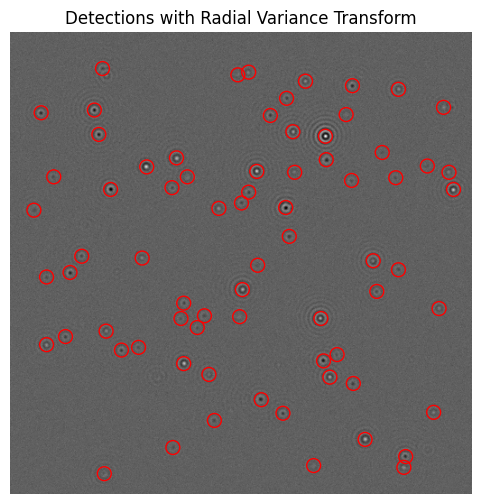

In [11]:
hp.plot_frame_with_detections(
    data=data,
    positions=detections_rvt,
    title="Detections with Radial Variance Transform"
    )

To evaluate the accuracy of our particle detection, we calculate the F1-score. By creating a mask of the ground truth particles with a preset radius, we can overlay this ground truth mask with the predicted mask to assess the detection performance.

In [12]:
radius = 6 #Radius of the particle in pixels

In [13]:
GT_particles = hp.add_bin_circles(centroids, radius) #Ground truth particles
P_particles = hp.add_bin_circles(detections_rvt, radius) #Detected particles

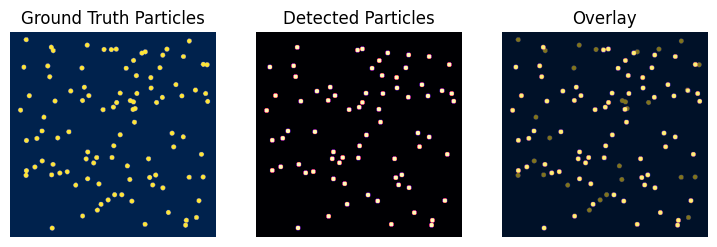

In [14]:
hp.plot_overlay(GT_particles, P_particles)

In [15]:
f1_score_rvt = hp.get_F1_score(P_particles, GT_particles)
print(f"F1 score for RVT: {round(f1_score_rvt * 100, 3)}%")

F1 score for RVT: 79.422%


### 2.2 Detecting particles using LodeSTAR model


We'll explore another approach for detecting particles known as the LodeSTAR method. This method employs a self-supervised neural network model that requires only one or a few training images for particle detection.

For more detailed information about this method, refer to the following paper:
- Midtvedt, B., Pineda, J., Skärberg, F. et al. "Single-shot self-supervised object detection in microscopy." Nat Commun 13, 7492 (2022). [Link to Paper](https://www.nature.com/articles/s41467-022-35004-y)


#### 2.2.1  Prepare the Training Crop
For training the network, we will need to provide one or a few training crops as input.

If applying this to your own data. One approach is to manually extract a few centroids of particles which are in fairly clear view.

In [16]:
crop_size = 64 #Size of the crops
labels_idx = [11, 33, 63, 84] #Indexes of the particles in the dataset
downsample = True #Downsample the images

In [17]:
# Calculate crop coordinates
crop_x0s = np.array(labels[labels_idx, 0] - crop_size/2, dtype=int)
crop_y0s = np.array(labels[labels_idx, 1] - crop_size/2, dtype=int)

# Masking for valid coordinates
valid_mask = ((crop_x0s - crop_size/2 > 0) & (crop_x0s + crop_size/2 < data.shape[0])
              & (crop_y0s - crop_size/2 > 0) & (crop_y0s + crop_size/2 < data.shape[1]))

# Filter out invalid crops
crop_x0s = crop_x0s[valid_mask]
crop_y0s = crop_y0s[valid_mask]

# Extract valid crops
crops = np.array([data[crop_x0:crop_x0 + crop_size, crop_y0:crop_y0 + crop_size, :] 
                  for crop_x0, crop_y0 in zip(crop_x0s, crop_y0s)])

if downsample:
    crops = skimage.measure.block_reduce(crops, (1, 2, 2, 1))
    crop_size = 32
    crop_x0s = crop_x0s + crop_size // 2
    crop_y0s = crop_y0s + crop_size // 2

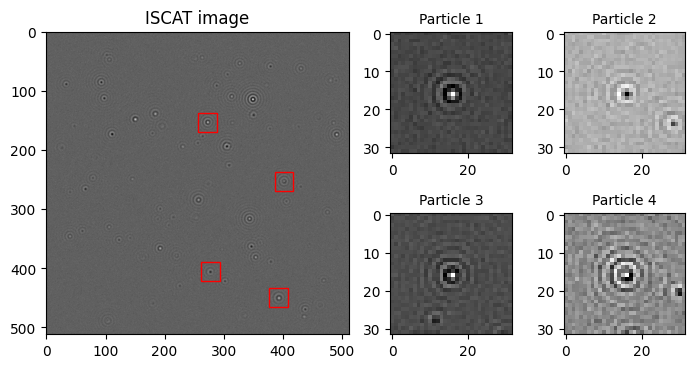

In [18]:
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
# Create the figure and the grid layout
fig = plt.figure(layout="constrained", figsize=(7, 6))
gs = GridSpec(4, 4, figure=fig)

# Main image
ax1 = fig.add_subplot(gs[:2, :2])
ax1.imshow(data[..., 0], cmap="gray")
ax1.set_title("ISCAT image")

# Add rectangles
for crop_x0, crop_y0 in zip(crop_x0s, crop_y0s):
    ax1.add_patch(patches.Rectangle((crop_y0, crop_x0), crop_size, crop_size,
                                    linewidth=1, edgecolor="r", facecolor="none"))

# Crop images
crop_positions = [(0, 2), (0, 3), (1, 2), (1, 3)]
for i, (x, y) in enumerate(crop_positions):
    ax = fig.add_subplot(gs[x, y])
    ax.imshow(crops[i][..., 0], cmap="gray")
    ax.set_title(f"Particle {i+1}", fontsize=10)
plt.show()

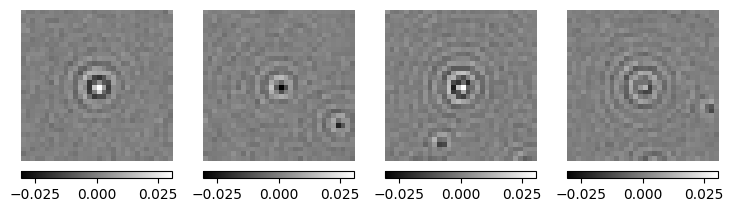

In [19]:
plt.figure(figsize=(9,3))
for i, crop in enumerate(crops):
    plt.subplot(1, len(labels_idx), 1+i)
    im = plt.imshow(crop[...,0], cmap="gray")
    plt.colorbar(im, fraction=0.046, pad=0.04, orientation = "horizontal")
    im.set_clim(-0.031, 0.031)
    plt.axis('off')
plt.show()

#### 2.2.2  Prepare pipeline for generating training samples and train the LodeSTAR model
We here create a pipeline for training the LodeSTAR model by adding some noise and scaling of the image values.

The initial noise we apply introduces a gradient onto the image.

In [20]:
# Create a meshgrid
X, Y = np.meshgrid(
    np.arange(crop_size)-crop_size,
    np.arange(crop_size)-crop_size
    )

#Gradient function
def grad(dx1, dy1):
    "Adds a gradient to the image"
    def inner(image):
        image[...,0]+=dx1*X+dy1*Y
        return image
    return inner

#Lambda layer which adds a gradient to the image
addgrad=dt.Lambda(
    grad,
    dx1=lambda: .01/crop_size*np.random.randn(),
    dy1=lambda: .01/crop_size*np.random.randn(),
    )

Here a training pipeline of the sequential added noise is defined.

In [21]:
training_pipeline = (
    dt.Value(lambda: crops[np.random.randint(len(crops))])
    >> addgrad
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 5e-3)
    >> dt.Multiply(lambda: np.random.uniform(-3, 3))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

In [22]:
#Training dataset. Setting the length to 10000 and replace to False.
training_dataset = dt.pytorch.Dataset(training_pipeline, length=10000, replace=False)

# Create a dataloader
dataloader = dl.DataLoader(training_dataset, batch_size=8, shuffle=True)

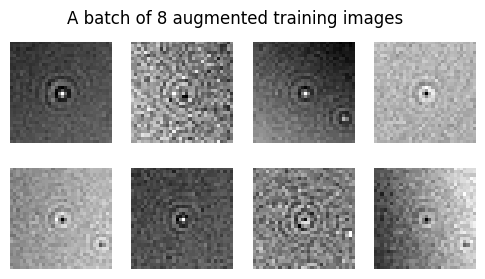

In [23]:
dataloader = dl.DataLoader(training_dataset, batch_size=8, shuffle=True)

batch = next(iter(dataloader))
plt.figure(figsize=(6, 3))
plt.suptitle("A batch of 8 augmented training images")
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(batch[0][i,0], cmap="gray")
    plt.axis("off")

Define and train the LodeSTAR model (or load in a pretrained model).

In [24]:
learning_rate = 2e-4
max_epochs = 50
TRAIN_MODEL = False
model_path = os.path.join("..", "models", "iscat", "lodestar_tracking.pth")

In [25]:
#Defining the model
lodestar = dl.LodeSTAR(n_transforms=4, optimizer=dl.Adam(lr=learning_rate)).build().to(DEV)

In [26]:
if TRAIN_MODEL:
    #Train model for max_epochs.
    trainer = dl.Trainer(max_epochs=50)
    trainer.fit(lodestar, dataloader)
else:
    lodestar.load_state_dict(torch.load(model_path))
    lodestar.eval()
lodestar = lodestar.to(DEV)


#### 2.2.3  Detect and visualize the results on the full frame

Let's visualize the particle detections on a full frame using the LodeSTAR model. The model includes a detect function, which can identify multiple particles within a full field of view. While some parameter tuning may be necessary, we've provided suitable initial values below.

In [27]:
#Parameters for the tracking
alpha = 0.8 
beta = 0.2
cutoff = 0.9925
mode = "quantile"

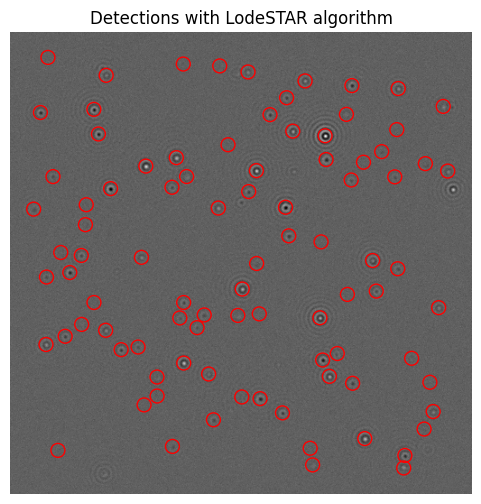

In [28]:
if downsample:
    datav2 = skimage.measure.block_reduce(data, (2, 2, 1))
    torch_image = torch.from_numpy(datav2).permute(2, 0, 1).unsqueeze(0).float().to(DEV)
    factor = 2
else:
    torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float().to(DEV)
    factor = 1

#Detect particles with LodeSTAR
detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                mode=mode, cutoff=cutoff)[0]*factor

hp.plot_frame_with_detections(
    data=data,
    positions=detections,
    title = "Detections with LodeSTAR algorithm"
    )

To evaluate the accuracy of our particle detection, we calculate the F1-score yet again.

In [29]:
P_particles = hp.add_bin_circles(detections, radius) #Detected particles

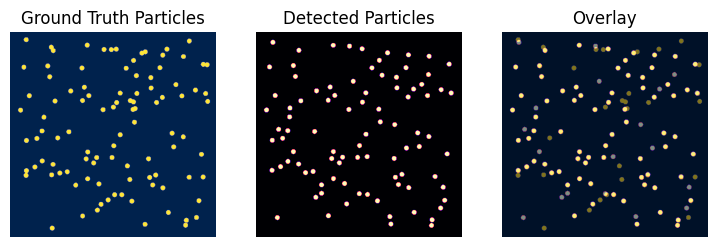

In [30]:
hp.plot_overlay(GT_particles, P_particles)

In [31]:
# F1 score for LodeSTAR
f1_score_l = hp.get_F1_score(P_particles, GT_particles)
print(f"F1 score for LodeSTAR: {round(f1_score_l * 100, 3)}%")

F1 score for LodeSTAR: 69.642%


## 3. Quantification of particle properties in ISCAT



It is now time to move to quantification of the particles. 

To analyze their signal we will look at region of interests (ROIs) around the particles, thus trying to extract the signal of the particles from an image.


In [32]:
padsize = 20 # Padding size, 20 pixels gives a total size of 40x40 pixels.

In [33]:
rois = hp.get_rois(data, centroids, padsize) #Get the ROIs

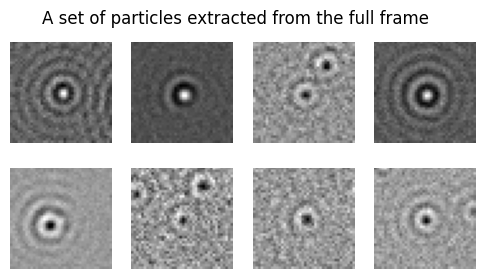

In [34]:
plt.figure(figsize=(6, 3))
plt.suptitle("A set of particles extracted from the full frame")
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(rois[i,...,0], cmap="gray")
    plt.axis("off")

To briefly summarize, the signal in ISCAT is determined by the product of the polarizability and the form factor. In the tutorial review, the derivations of this expression can be found.

TODO - add expression here


In [35]:
#Calculate the polarizabilities for all the particles
polarizabilities_rois = hp.get_polarizability(labels[:,3]*1e6, labels[:,4])

#Calculate the form factors for all the particles
form_factors = hp.form_factor(labels[:,3]*1e6, wavelength = 0.532)

#Calculate the signal for all the particles
signal_rois = np.array(
    [hp.signal_iscat(form_factor, polarizability) for form_factor, polarizability in zip(form_factors, polarizabilities_rois)]
    )

### 3.2 Quantifying particle signal using a 2DCNN

We will now implement a 2-D Convolutional Neural Network(CNN) to learn how to estimate the integrated scattering intensity in ISCAT. The input will here be an image of a particles scattering pattern, and the label will be de theoretical integrated scattering intensity.

#### 3.2.1 Defining the optical system

First of we define the optical system of which we image the particles in.

In [36]:
IMAGE_SIZE = 40
NA = 1
MAGNIFICATION = 1
WAVELENGTH = 532e-9
RESOLUTION = 1.14e-7

In [37]:
optics = dt.ISCAT(
    NA=NA,
    magnification=MAGNIFICATION,
    wavelength=WAVELENGTH,
    resolution=RESOLUTION,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    illumination_angle=np.pi,
)

#### 3.2.2 Defining the particle(s)

We define spherical particles with a radius ranging from 25nm to 250nm and a refractive index ranging from 1.37 to 1.6.

In [38]:
RADIUS_RANGE = (25e-9, 250e-9)
REFRACTIVE_INDEX_RANGE = (1.37, 1.6)

In [39]:
particle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.randn(2),
    z=lambda: np.random.randn() * 5,
    radius=lambda:np.random.uniform(*RADIUS_RANGE),
    refractive_index=lambda: np.random.uniform(*REFRACTIVE_INDEX_RANGE),
    L=8,
    position_unit="pixel",
)

#### 3.2.3 Create dataset of particles

Here we define a dataset-pipeline which images the particles in a ISCAT setup. We add some gaussian noise of different signal-to-noise ratios (SNRs).

In [40]:
def add_noise(snr=10):
    """
    Add noise to an image with a given signal-to-noise ratio (SNR).

    Args:
        snr (float): The signal-to-noise ratio.
        
    Returns:
        A function that adds noise to an image.
        """

    def inner(image):
        slevel=np.std(image)
        
        nlevel=slevel/snr
        image+=nlevel*np.random.randn(*image.shape)
        return image
    return inner

noise_snr = dt.Lambda(add_noise, snr=lambda: np.random.uniform(0.5, 5))

In [41]:
dataset = optics(particle >> dt.Gaussian(sigma=1e-5)) >> dt.Subtract(1) >> noise_snr  

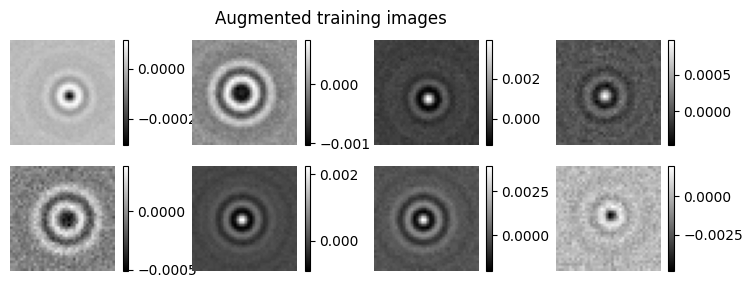

In [42]:
plt.figure(figsize=(9, 3))
plt.suptitle("Augmented training images")
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(dataset.update().resolve()[...,0], cmap="gray")
    plt.colorbar()
    plt.axis("off")

#### 3.2.4 Defining the training label

We here define functions to extract the parameters we want the network to learn, i.e. the integrated scattering intensity.

In [43]:
MIN, MAX = hp.signal_range(RADIUS_RANGE, REFRACTIVE_INDEX_RANGE)
print("Signal range:", MIN, MAX)

Signal range: 1.2125533639949535e-08 0.011968181042412427


In [44]:
def get_label_iscat(radius, refractive_index, wavelength=WAVELENGTH*1e6, nm=1.333, factor=1):
    """
    Get the label for the ISCAT image.

    Args:
        radius (float): The radius of the particle in meters.
        refractive_index (float): The refractive index of the particle.
        wavelength (float): The wavelength of the light in meters.
        nm (float): The refractive index of the medium.
        factor (float): A scaling factor for the signal.

    Returns:
        A function that calculates the label for the ISCAT image.
    """


    def inner(image):
        #Calculate the standard deviation of the image
        std=np.std(image)

        #Calculate the polarizability and form factor
        pol = hp.get_polarizability(radius=radius*1e6, refractive_index=refractive_index, refractive_index_medium=nm)
        form_factor = hp.form_factor(radius=radius*1e6, nm=nm, wavelength=wavelength)

        #Calculate the signal
        signal = hp.signal_iscat(form_factor, pol) / (factor*MAX*std)
    
        return np.expand_dims(signal, -1)
    return inner


#### 3.2.5 Creating a model (2DCNN) for quantification.

We create a neural network with a convolutional part consisting of 3 layers and a multi-layer perceptron with 2 hidden layers. The network uses leaky ReLU activation functions with a slope of 0.1 for the outputs. We denote that the model architecture can be adjusted as required.

In [45]:
conv = dl.ConvolutionalNeuralNetwork(
    in_channels=1, 
    hidden_channels=[16, 32, 64], 
    out_channels=64,
    pool=dl.torch.nn.MaxPool2d(kernel_size=2),
    out_activation=dl.torch.nn.LeakyReLU(0.1),
    )

mlp = dl.MultiLayerPerceptron(
    in_features=None, 
    hidden_features=[64, 32], 
    out_activation=dl.torch.nn.LeakyReLU(0.1), 
    out_features=1
    )

net = dl.Sequential(
    conv,
    mlp
    )

We define the model as regressor and utilize Mean Absolute Error(MAE) loss with the Adam optimizer.

In [46]:
regressor = dl.Regressor(
    model=net,
    loss=dl.torch.nn.L1Loss(),
    optimizer=dl.Adam(),
)

cnn_regressor = regressor.create()
cnn_regressor = cnn_regressor.to(DEV)

#### 3.2.6 Training of the model

We construct an image-signal pipeline that generates images along with their corresponding labels. The particles will be scaled by their standard deviation aswell as a factor of 10.

In [47]:
def scale_std(factor=1):
    """
    Returns a function that scales an image by the standard deviation of its pixel values,
    divided by the specified factor.
    
    Parameters:
    - factor (int or float): The factor to divide the standard deviation by.
    
    Returns:
    - function: A function that scales an image.
    """
    def inner(image):
        std = np.std(image)  # Calculate the standard deviation of the image
        return image / (factor * std)  # Scale the image by the calculated value
    return inner
    
#Set the scale function    
scale = dt.Lambda(scale_std, factor=10)

In [48]:
#Pipeline for generating images and labels.
image_and_signal_pipeline = dataset >> scale & dataset >> dt.Lambda(get_label_iscat, radius=particle.radius, refractive_index=particle.refractive_index, factor=10)

In [49]:
#Training dataset
training_dataset = dt.pytorch.Dataset(image_and_signal_pipeline, length=100000, replace=False)
dataloader = dl.DataLoader(training_dataset, batch_size=32, shuffle=True)

#Validation dataset
val_dataset = dt.pytorch.Dataset(image_and_signal_pipeline, length=1000)
val_dataloader = dl.DataLoader(val_dataset, batch_size=32, shuffle=False)

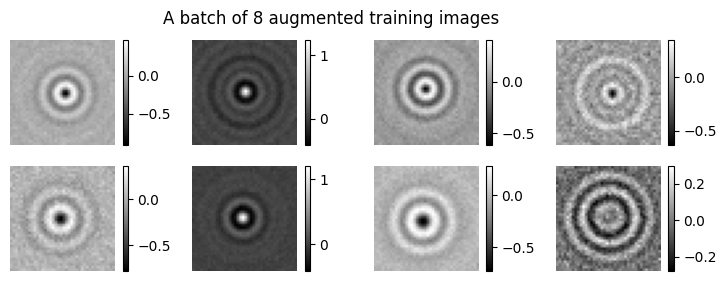

In [50]:
batch = next(iter(dataloader))
plt.figure(figsize=(9, 3))
plt.suptitle("A batch of 8 augmented training images")
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(batch[0][i,0], cmap="gray")
    plt.colorbar()
    plt.axis("off")

In [51]:
max_epochs = 50
TRAIN_MODEL = False
model_path = os.path.join("..", "models", "iscat", "cnn_regressor.pth")

In [52]:
if TRAIN_MODEL:
    #Train model for max_epochs.
    trainer = dl.Trainer(max_epochs=max_epochs)
    trainer.fit(cnn_regressor, dataloader, val_dataloader)
else:
    cnn_regressor.load_state_dict(torch.load(model_path))
    cnn_regressor.eval()
cnn_regressor = cnn_regressor.to(DEV)


#### 3.2.7 Validating the model on simulated data and ROIs from the full frame.

To validate that the model we predict on the valiation set and the ROIs extracted from the full frame


In [53]:
#Predict the signal on validation dataset
predictions = []
labels_ = []
for batch in val_dataloader:
    predictions.append(cnn_regressor(batch[0].to(DEV)))
    labels_.append(batch[1])

#Concatenate the predictions and labels
predictions = torch.concatenate(predictions)[:, 0].detach().cpu().numpy()
labels_ = torch.concatenate(labels_)[:, 0].detach().cpu().numpy()

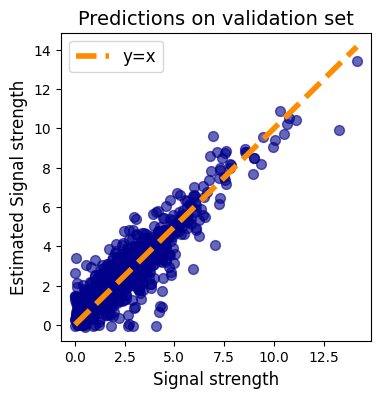

In [54]:
hp.visualize_lab_pred(labels_, predictions)

In [55]:
#Predict on the rois
predictions_rois = [
    cnn_regressor((torch.from_numpy(roi)/np.std(roi*10)).permute(2, 0, 1).unsqueeze(0).to(DEV)) 
    for roi in rois]

# Extract predictions and standard deviations
predictions_rois = np.array([pred.item() for pred in predictions_rois])
stds = np.array([np.std(roi) for roi in rois])

# Scale predictions by standard deviations
predictions_rois *= stds

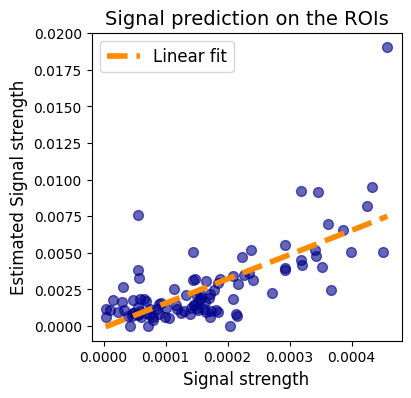

In [56]:
hp.visualize_lab_pred(
    signal_rois, 
    predictions_rois,
    title="Signal prediction on the ROIs",
    linfit=True
    )

### 3.4 We investigate the signal's dependence while fixing either the refractive index or the radius.

In the following section the signal dependence in two scenarios is analyzed 1. Fixed refractive index, 2. Fixed radius

#### 3.4.1 Fix refractive index

The refractive index is set to 1.4 for all particles.

In [57]:
FIX_RI = 1.4
RADIUS_RANGE = np.linspace(25e-9, 250e-9, 100)
samples_per_case = 10
noise_snr = 3
radiuses = np.concatenate([np.repeat(x, samples_per_case) for x in RADIUS_RANGE])

In [58]:
DATA = []
for i, rad in enumerate(RADIUS_RANGE):
    if i % 10 == 0:
        print(f"Simulating... {i}/{len(RADIUS_RANGE)}")

    #Get all the particles
    for _ in range(samples_per_case):
        im = dataset.update().resolve(refractive_index=FIX_RI, radius=rad, snr=noise_snr)
        DATA.append(im)
DATA = np.array(DATA)

#Normalize the data with the standard deviation and a factor of 10
stds = np.std(DATA, axis=(1,2,3), keepdims=True)*10
DATA = DATA / stds

Currently at 0/100
Currently at 10/100
Currently at 20/100
Currently at 30/100
Currently at 40/100
Currently at 50/100
Currently at 60/100
Currently at 70/100
Currently at 80/100
Currently at 90/100


In [59]:
# Get the theoretical signals
theoretical_pol = hp.get_polarizability(radiuses, FIX_RI)
form_factors = hp.form_factor(radiuses*1e6, wavelength=0.532)
theoretical_signal = np.array(
    [hp.signal_iscat(form_factor, polarizability) for form_factor, polarizability in zip(form_factors, theoretical_pol)]
    )

In [60]:
#Predict the signal on the dataset
signal_cnn_fix_ri = cnn_regressor(
    torch.from_numpy(DATA).permute(0, 3, 1, 2).float().to(DEV)
    ).cpu().detach().numpy()[:, 0] * np.squeeze(stds)

In [61]:
#Normalize the signals with the mean
signal_cnn_fix_ri = signal_cnn_fix_ri / signal_cnn_fix_ri.mean()
theoretical_signal = theoretical_signal / theoretical_signal.mean()

Text(0.5, 1.0, 'Theoretical vs. Estimated signal with a 2DCNN')

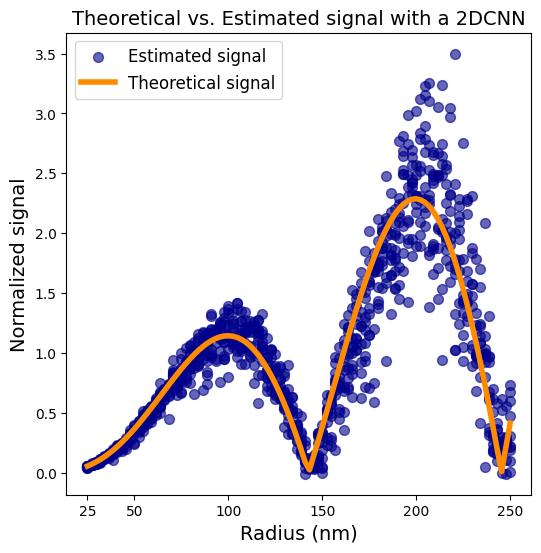

In [62]:
plt.figure(figsize=(6, 6))
plt.scatter(radiuses, signal_cnn_fix_ri, color="darkblue", alpha=0.6, s=50, label = 'Estimated signal')

#Line for theoretical signal
plt.plot(radiuses, theoretical_signal, linestyle="-", linewidth=4, label="Theoretical signal", color = 'darkorange')

plt.xticks([25e-9, 50e-9, 100e-9, 150e-9, 200e-9, 250e-9], ["25", "50", "100", "150", "200", "250"])
plt.xlabel("Radius (nm)", fontsize=14)
plt.ylabel("Normalized signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("Theoretical vs. Estimated signal with a 2DCNN", fontsize=14)

#### 3.4.1 Fix radius

The radius is set to 100nm for all particles.

In [63]:
FIX_RADIUS = 100e-9
RI_RANGE = np.linspace(1.37, 1.6, 100)
samples_per_case = 10
noise_snr = 3
riis = np.concatenate([np.repeat(x, samples_per_case) for x in RI_RANGE])

In [64]:
DATA = []
for i, ri in enumerate(RI_RANGE):
    if i % 10 == 0:
        print(f"Simulating... {i}/100")

    #Get all the particles
    for _ in range(samples_per_case):
        im = dataset.update().resolve(refractive_index=ri, radius=FIX_RADIUS, snr=noise_snr)
        DATA.append(im)
DATA = np.array(DATA)

#Normalize the data with the standard deviation and a factor of 10
stds = np.std(DATA, axis=(1,2,3), keepdims=True)*10
DATA = DATA / stds

Currently at 0/100
Currently at 10/100
Currently at 20/100
Currently at 30/100
Currently at 40/100
Currently at 50/100
Currently at 60/100
Currently at 70/100
Currently at 80/100
Currently at 90/100


In [65]:
# Get the theoretical signals
theoretical_pol = hp.get_polarizability(FIX_RADIUS*1e6, riis)
form_factors = hp.form_factor(FIX_RADIUS*1e6, wavelength=0.532)
form_factors = np.repeat(form_factors, len(riis))
theoretical_signal = np.array(
    [hp.signal_iscat(form_factor, polarizability) for form_factor, polarizability in zip(form_factors, theoretical_pol)]
    )

In [66]:
#Predict the signal on the dataset
signal_cnn_fix_radius = cnn_regressor(
    torch.from_numpy(DATA).permute(0, 3, 1, 2).float().to(DEV)
    ).cpu().detach().numpy()[:, 0] * np.squeeze(stds)

In [67]:
#Normalize the signals with themean
signal_cnn_fix_radius = signal_cnn_fix_radius / signal_cnn_fix_radius.mean()
theoretical_signal = theoretical_signal / theoretical_signal.mean()

Text(0.5, 1.0, 'Theoretical vs. Estimated signal with a 2DCNN')

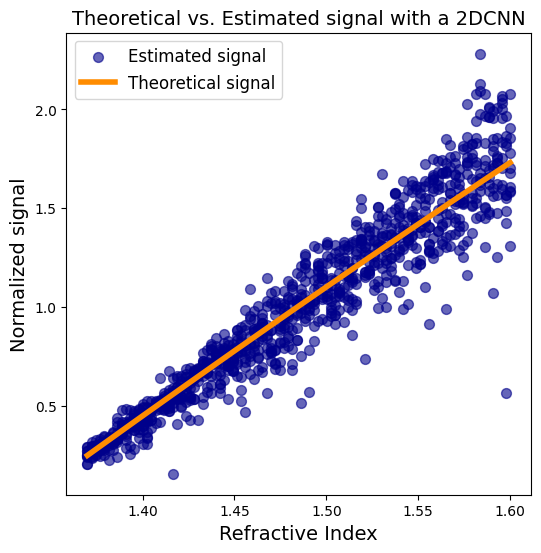

In [68]:
plt.figure(figsize=(6, 6))
plt.scatter(riis, signal_cnn_fix_radius, color="darkblue", alpha=0.6, s=50, label = 'Estimated signal')

#Line for theoretical
plt.plot(riis, theoretical_signal, linestyle="-", linewidth=4, label="Theoretical signal", color = 'darkorange')

plt.xlabel("Refractive Index", fontsize=14)
plt.ylabel("Normalized signal", fontsize=14)
plt.legend(fontsize=12)
plt.title("Theoretical vs. Estimated signal with a 2DCNN", fontsize=14)

## 4. Combining detection and quantification in ISCAT

Lastly we provide a example on how to combine detection and quantification on a full frame.

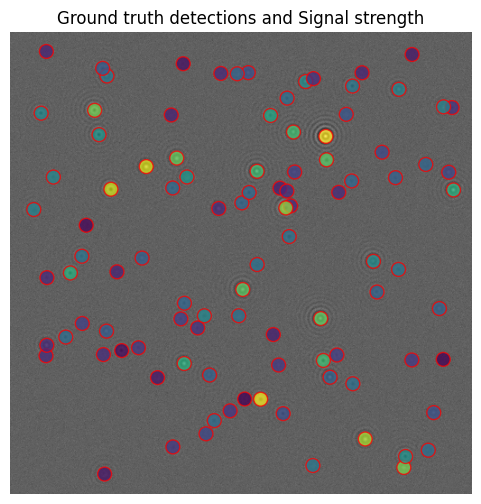

In [69]:
hp.plot_frame_with_detections_filled(
    data=data[...,0],
    positions=centroids,
    values=signal_rois,
    title="Ground truth detections and Signal strength",
    )

### 4.1 LodeSTAR and 2DCNN for particle detection and quantification

In [70]:
def LodeSTAR_2dcnn_full_frame_pipeline(data, lodestar, cnn_regressor, alpha=0.5, beta=0.5, cutoff=0.95, padsize=20, downsample=False):
    """
    Pipeline for detecting particles in a full frame darkfield image and predicting the signal strength.

    Args:
        data (np.array): The full frame darkfield image.
        lodestar (LodeSTAR): The LodeSTAR model.
        cnn_regressor (torch.nn.Module): The CNN regressor model.
        alpha (float): The alpha parameter for LodeSTAR.
        beta (float): The beta parameter for LodeSTAR.
        cutoff (float): The cutoff parameter for LodeSTAR.
        padsize (int): The padding size for the ROIs.
        downsample (bool): If True, downsample the image by a factor of 2.

    Returns:
        A tuple with the detections and the signals.
    """

    #Detect particles with LodeSTAR
    if downsample:
        datav2 = skimage.measure.block_reduce(data, (2, 2, 1)) 
        torch_image = torch.from_numpy(datav2).permute(2, 0, 1).unsqueeze(0).float().to(DEV)
        factor = 2
    else:
        torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float().to(DEV)
        factor = 1

    detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                    mode="quantile", cutoff=cutoff)[0] * factor

    #If no detections, throw error.
    if len(detections) > 0:
        
        #Check so detections is not out of bounds
        detections = detections[(detections[:,0] > padsize) & (detections[:,0] < data.shape[0] - padsize) & 
                                (detections[:,1] > padsize) & (detections[:,1] < data.shape[1] - padsize)]

        #Get the signals
        signals = np.array([
            cnn_regressor(torch.from_numpy(roi).permute(2, 0, 1).unsqueeze(0).float().to(DEV)).cpu().detach().numpy()[0, 0] 
            for roi in hp.get_rois(data, detections, padsize)])

        return detections, signals

    else:
        print("No detections")

In [71]:
detections, signals = LodeSTAR_2dcnn_full_frame_pipeline(
    data, 
    lodestar, 
    cnn_regressor, 
    alpha=alpha, 
    beta=beta, 
    cutoff=cutoff, 
    padsize=padsize, 
    downsample=downsample
    )

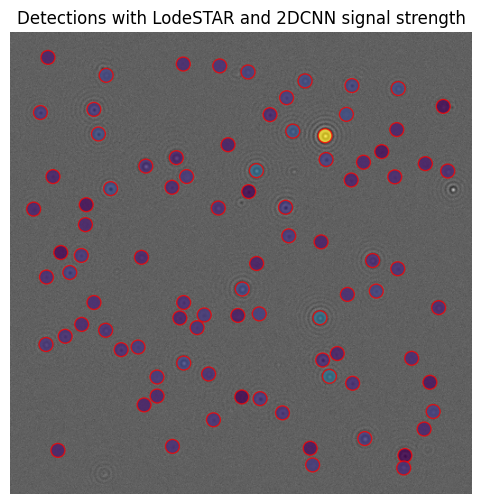

In [72]:
hp.plot_frame_with_detections_filled(
    data=data[...,0],
    positions=detections,
    values=signals,
    title="Detections with LodeSTAR and 2DCNN signal strength",
    )